In [1]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)
from tree_detection_framework.detection.detector import GeometricDetector
from tree_detection_framework.postprocessing.postprocessing import (
    merge_and_postprocess_detections,
    multi_region_hole_suppression,
    single_region_hole_suppression,
    multi_region_NMS,
)
import time

/home/exouser/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (None)/charset_normalizer (3.4.1) doesn't match a supported version!
  warnings.warn(
/home/exouser/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    resolution=0.2,
)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400


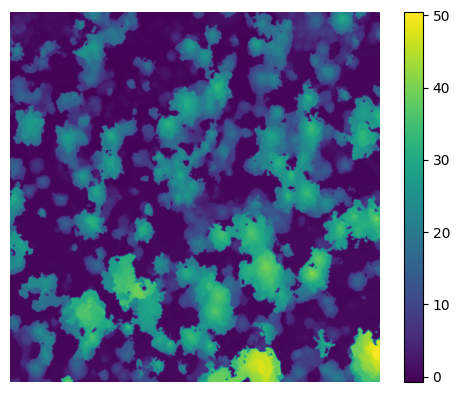

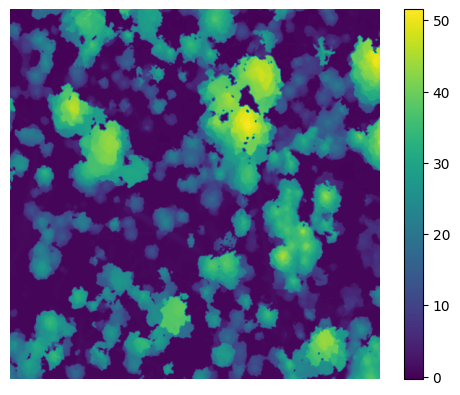

In [3]:
visualize_dataloader(dataloader, 2)

Create GeometricDetector and get predictions
--

Experiementing time taken with different filter_shapes

In [4]:
detector = GeometricDetector(
    a=0.0045,
    confidence_feature="distance",
    filter_shape="square",
)

start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(
    f"Time taken to get predictions using filter_shape SQUARE : {end_time - start_time} seconds"
)

Performing prediction on batches: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

Time taken to get predictions using filter_shape SQUARE : 4.657593011856079 seconds


In [6]:
detector = GeometricDetector(
    a=0.0045,
    confidence_feature="distance",
    filter_shape="circle",
)
start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(
    f"Time taken to get predictions using filter_shape CIRCLE : {end_time - start_time} seconds"
)

Performing prediction on batches: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Time taken to get predictions using filter_shape CIRCLE : 6.717634916305542 seconds


In [8]:
detector = GeometricDetector(
    a=0.0045,
    confidence_feature="distance",
    filter_shape="none",
)

start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(
    f"Time taken to get predictions using filter_shape NONE (bruteforce) : {end_time - start_time} seconds"
)

Performing prediction on batches:   0%|          | 0/6 [00:00<?, ?it/s]INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
Performing prediction on batches:  17%|█▋        | 1/6 [00:15<01:16, 15.20s/it]INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
Performing prediction on batches:  33%|███▎      | 2/6 [00:26<00:51, 12.97s/it]INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No filter applied to the image. Using brute-force method.
Performing prediction on batches:  50%|█████     | 3/6 [00:37<00:36, 12.18s/it]INFO:root:No filter applied to the image. Using brute-force method.
INFO:root:No

Time taken to get predictions using filter_shape NONE (bruteforce) : 52.55343317985535 seconds


Plotting the raw predictions before post-processing
--

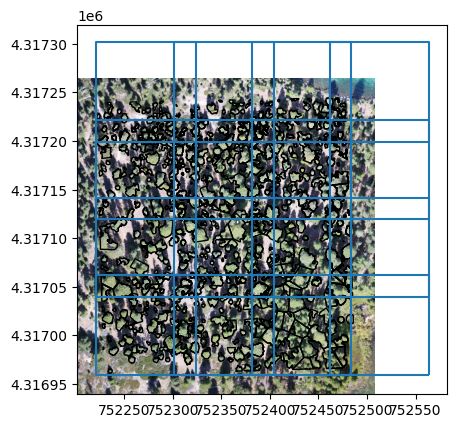

<Axes: >

In [9]:
predictions.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

NMS
---

In [8]:
postprocessed = multi_region_NMS(predictions)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2025-01-17 23:47:58,098 - INFO - Bound have overlap, running across-region NMS
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


NMS with "distance"
--

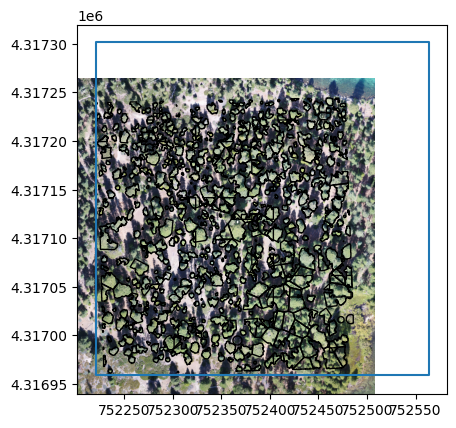

In [9]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

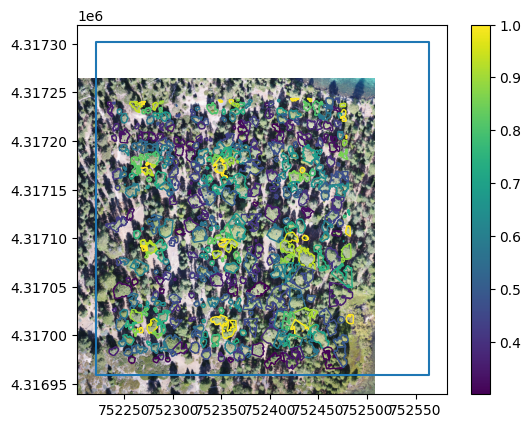

In [9]:
# Visualizing score column
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif",
    visualization_column="score",
)

Note how higher confidence detections (yellow) are in the centers of each sub-grid/tile

NMS with "area"
--

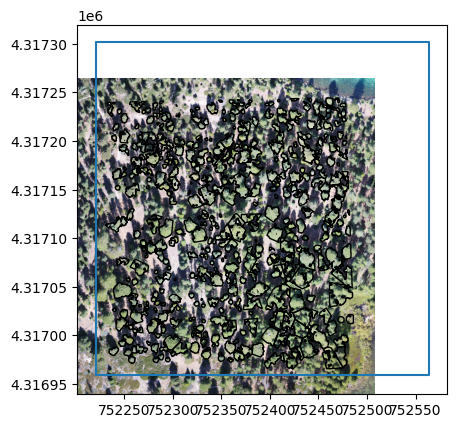

<Axes: >

In [9]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

NMS with "height"
--

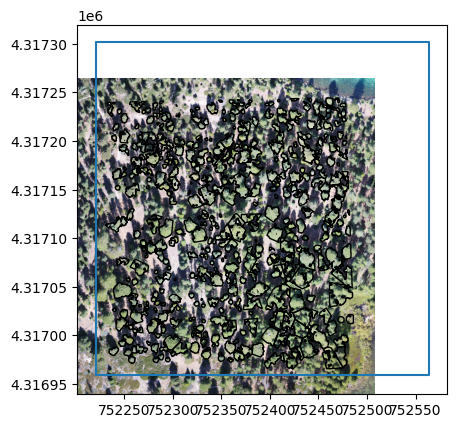

<Axes: >

In [10]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

After suppressing polygon holes
--

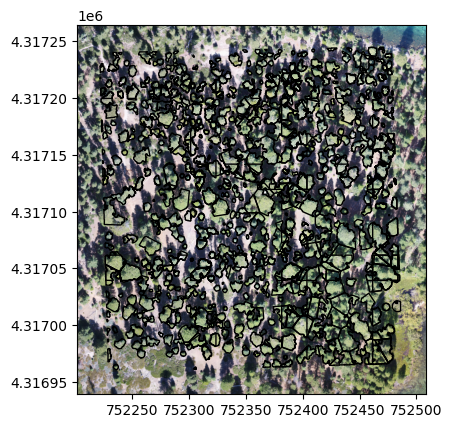

<Axes: >

In [8]:
hole_suppressed = multi_region_hole_suppression(predictions)

hole_suppressed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

Another way to post-process: Merging and simplifying crowns
---
This performs polygon hole supression within the function

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


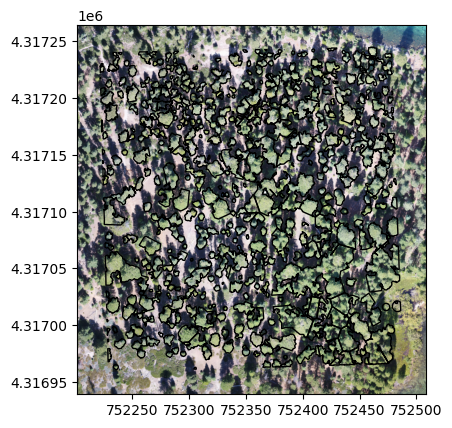

In [9]:
postprocessed = merge_and_postprocess_detections(predictions)

postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

In [ ]:
postprocessed.save(
    "/ofo-share/repos-amritha/extras/tdf/output_gpkgs/geometric_detections_multipolygon_filtered.gpkg"
)

2024-12-05 20:20:01,667 - INFO - Created 547 records


Single region hole suppression
--

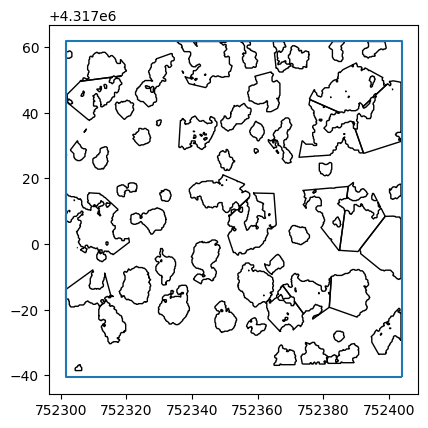

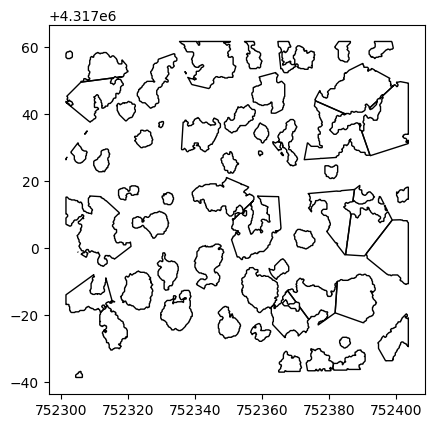

In [ ]:
# Get a RegionDetections object
region = predictions.region_detections[1]
region.plot()  # Before

postprocessed_region = single_region_hole_suppression(region)
postprocessed_region.plot()  # After